In [ ]:
!pip install keras

In [ ]:
#importing required libraries

import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense,InputLayer,Embedding,Conv1D,MaxPooling1D,Input,LSTM,BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping,Callback
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import plotly.figure_factory as ff
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string
import datetime
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# set display option for rows & columns

pd.set_option( 'display.max_rows', None)
pd.set_option('display.max_columns', None )

In [ ]:
train_data=pd.read_csv('/content/train_preprocess.csv')
train_data.head()

,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,i would have responded if i were going,i would have responded if i were going,neutral,would responded going
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,sooo sad miss san diego
2,088c60f138,my boss is bullying me,bullying me,negative,boss bullying
3,9642c003ef,what interview leave me alone,leave me alone,negative,interview leave alone
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,sons couldnt put releases already bought


In [ ]:
sentiment_counts = train_data['sentiment'].value_counts()
sentiment_counts

,count
sentiment,
neutral,11114
positive,8577
negative,7685


In [ ]:
# text column max length
maxlentext = train_data['text'].apply(lambda x:len(str(x).split())).tolist()
print(max(maxlentext))

32


In [ ]:
# creating target column for vector representation of selected_text
train_data['Target'] = ""

In [ ]:
def Start_index(x, selectx, index):
  indice = []
  train_text = x
  train_selected_txt = selectx
  text = train_text.split()
  selected = train_selected_txt.split()

  for txt in text:
    # if text present replace with 1, else 0
    if txt in selected:
     indice.append(1)
    else:
     indice.append(0)

  train_data["Target"][index]= indice

In [ ]:
#apply function on train data column
for i in range(len(train_data)):
  Start_index(train_data["text"][i], train_data["selected_text"][i], i)

In [ ]:
train_data.head(5)

,textID,text,selected_text,sentiment,clean_text,Target
0,cb774db0d1,i would have responded if i were going,i would have responded if i were going,neutral,would responded going,"[1, 1, 1, 1, 1, 1, 1, 1]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,sooo sad miss san diego,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,088c60f138,my boss is bullying me,bullying me,negative,boss bullying,"[0, 0, 0, 1, 1]"
3,9642c003ef,what interview leave me alone,leave me alone,negative,interview leave alone,"[0, 0, 1, 1, 1]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,sons couldnt put releases already bought,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
def downsample_neutral(group):
    if group.name == 'neutral':
        return group.sample(frac=0.5, random_state=42)
    return group

train_data = train_data.groupby('sentiment', group_keys=False).apply(downsample_neutral)

In [ ]:
sentiment_counts = train_data['sentiment'].value_counts()
sentiment_counts

,count
sentiment,
positive,8577
negative,7685
neutral,5557


# Train-Validation-Test data split

In [ ]:
#Train-Validation-Test data split
X = train_data[["text","sentiment","selected_text"]]
y = train_data["Target"]

# First split: Train and Test (15% for test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=X['sentiment'])

# Second split: Train and Validation (15% of the training set for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=X_train['sentiment'])


In [ ]:
#shapes after splitting

print("X_train shape => ", X_train.shape, "X_val shape =>", X_val.shape, "X_test shape =>", X_test.shape)
print("y_train shape =>", y_train.shape,"y_val shape =>", y_val.shape, "y_test shape =>", y_test.shape)

X_train shape =>  (15764, 3) X_val shape => (2782, 3) X_test shape => (3273, 3)
y_train shape => (15764,) y_val shape => (2782,) y_test shape => (3273,)


In [ ]:
#Padding the target variable

y_train = pad_sequences(y_train, maxlen = 33, padding = 'post', dtype = "float32")
y_val = pad_sequences(y_val, maxlen = 33, padding = 'post', dtype = "float32")
y_test = pad_sequences(y_test, maxlen = 33, padding = 'post', dtype = "float32")

print("The shape generated for y_train data is : ", (y_train.shape))
print("The shape generated for y_val data is  : ", (y_val.shape))
print("The shape generated for y_test data is  : ", (y_test.shape))

The shape generated for y_train data is :  (15764, 33)
The shape generated for y_val data is  :  (2782, 33)
The shape generated for y_test data is  :  (3273, 33)


# Tokenization and Padding

In [ ]:
#Tokenizer Word Embeddings on the text data col.
t = Tokenizer(lower = True)
t.fit_on_texts(X_train['text'].values)

#output sentence in a numeric form
x_train_sequences = t.texts_to_sequences(X_train['text'].values)
x_val_sequences = t.texts_to_sequences(X_val['text'].values)
x_test_sequences = t.texts_to_sequences(X_test['text'].values)

#maximum length for word
max_Length_ = int(np.max(np.array(([len(s) for s in x_train_sequences]))))


#No. of words in longest sentence and padding shorter len sentences
X_train_text_Padded = pad_sequences(x_train_sequences, maxlen = max_Length_, padding = 'post')
X_val_text_Padded = pad_sequences(x_val_sequences, maxlen = max_Length_, padding = 'post')
X_test_text_Padded = pad_sequences(x_test_sequences, maxlen = max_Length_, padding = 'post')

print("The shape for X_train_text : ",(X_train_text_Padded.shape))
print("The shape for X_val_text  : ",(X_val_text_Padded.shape))
print("The shape for X_test_text  : ",(X_test_text_Padded.shape))

#No. of unique words in the text using length
vocab_size_is = len(t.word_index) + 1
print("Maximum length of word     :", max_Length_)
print("Number of word/vocab_size  :", vocab_size_is)

The shape for X_train_text :  (15764, 32)
The shape for X_val_text  :  (2782, 32)
The shape for X_test_text  :  (3273, 32)
Maximum length of word     : 32
Number of word/vocab_size  : 18744


In [ ]:
#Tokenizing Word embeddings on the sentiment data
token = Tokenizer(lower = True)
token.fit_on_texts(X_train['sentiment'].values)

#numerical form sentence
x_train_sentiment = token.texts_to_sequences(X_train['sentiment'].values)

#val and test data
x_val_sentiment = token.texts_to_sequences(X_val['sentiment'].values)
x_test_sentiment = token.texts_to_sequences(X_test['sentiment'].values)

#max length of word
max_length_1 = int(np.max(np.array(([len(s) for s in x_train_sentiment]))))


#No. of words in longest sentence & padding shorter length sentence
X_train_sentiment_padded = pad_sequences(x_train_sentiment, maxlen = max_length_1, padding='post')
X_val_sentiment_padded = pad_sequences(x_val_sentiment, maxlen = max_length_1, padding='post')
X_test_sentiment_padded = pad_sequences(x_test_sentiment, maxlen = max_length_1, padding='post')

#final shapes
print("The shape for X_train_sentiment are : ",(X_train_sentiment_padded.shape))
print("The shape for X_val_sentiment are  : ",(X_val_sentiment_padded.shape))
print("The shape for X_test_sentiment are  : ",(X_test_sentiment_padded.shape))

#No. of unique words in text
vocab_size_ = len(token.word_index) + 1

print("The maximum length of word          :", max_length_1)
print("The number of word/vocab_size       :", vocab_size_)

sentimentWordIndex = token.word_index
print("Sentiments                          :",sentimentWordIndex)

The shape for X_train_sentiment are :  (15764, 1)
The shape for X_val_sentiment are  :  (2782, 1)
The shape for X_test_sentiment are  :  (3273, 1)
The maximum length of word          : 1
The number of word/vocab_size       : 4
Sentiments                          : {'positive': 1, 'negative': 2, 'neutral': 3}


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-04-10 12:38:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-10 12:38:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-10 12:38:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


# Word embeddings

In [ ]:
# Glove Word Embedding

embeddings_index = dict()
filepath = open('glove.6B.300d.txt')

for line in filepath:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype = 'float32')
	embeddings_index[word] = coefs
filepath.close()

print("Loaded %s word vectors..." % len(embeddings_index))

# word weight matrix
embedding_matrix = np.zeros((vocab_size_is, 300))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors...


In [ ]:
#for sentiments

embedding_matrix_sentiment = np.zeros((vocab_size_, 300))
for word, i in token.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix_sentiment[i] = embedding_vector

# Deep Learning Model_LSTM

In [ ]:
# LSTM

from tensorflow.keras.layers import Lambda

tf.keras.backend.clear_session()
text_input = Input(shape = (max_Length_,), name='text_input', dtype='int32')


#glove vector embedding
embd_text = Embedding(vocab_size_is,
                    300,
                    weights = [embedding_matrix],
                    input_length = max_Length_,
                    trainable = False, mask_zero = True, name = 'embedding_text')(text_input)


sentiment_input = Input(shape = (1,), name = 'sentiment_input', dtype='int32')

embd_sentiment = Embedding(4,
                    300,
                    weights = [embedding_matrix_sentiment],
                    input_length = 1,
                    trainable = False, mask_zero = True, name = 'embedding_sentiment')(sentiment_input)


#debug: try another way
def identity_force_infer(x):
    return tf.identity(x)

embd_text_checked = Lambda(identity_force_infer)(embd_text)
embd_sentiment_checked = Lambda(identity_force_infer)(embd_sentiment)

con = layers.Concatenate(axis=1)([embd_text_checked, embd_sentiment_checked])

#LSTM
lstm = LSTM(64, return_sequences = True, kernel_regularizer = regularizers.l2(0.001), name = 'LSTM')(con)

#Dense Layer with the dropouts
m = Dense(32, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(lstm)
m = Dropout(0.5)(m)
m = BatchNormalization()(m)
m = Dense(4, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(m)
output = Dense(1, activation = 'sigmoid', name = 'output')(m)

model = Model(inputs = [text_input, sentiment_input], outputs = [output])

#model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_text            │ (None, 32, 300)        │      6,459,900 │ text_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 32)             │              0 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_sentiment       │ (None, 1, 300)         │          1,200 │ sentiment_input[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 1)              │              0 │ sentiment_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32, 300)        │              0 │ embedding_text[0][0],  │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 300)         │              0 │ embedding_sentiment[0… │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 33, 300)        │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM (LSTM)               │ (None, 33, 64)         │         93,440 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 33, 32)         │          2,080 │ LSTM[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 33, 32)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 33, 32)         │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 33, 4)          │            132 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 33, 1)          │              5 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,556,885 (25.01 MB)

 Trainable params: 95,721 (373.91 KB)

 Non-trainable params: 6,461,164 (24.65 MB)

None


In [ ]:
#train-test dimensions
y_train = np.expand_dims(y_train, -1)
y_val = np.expand_dims(y_val, -1)
y_test = np.expand_dims(y_test, -1)
print("The train set dimensions:", y_train.shape)
print("The val set dimensions :", y_val.shape)
print("The test set dimensions :", y_test.shape)

The train set dimensions: (15764, 33, 1)
The val set dimensions : (2782, 33, 1)
The test set dimensions : (3273, 33, 1)


In [ ]:
y_train[:5]

array([[[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[1.],
        [1.],
        [1.],
        [1.],
        [1.],
  

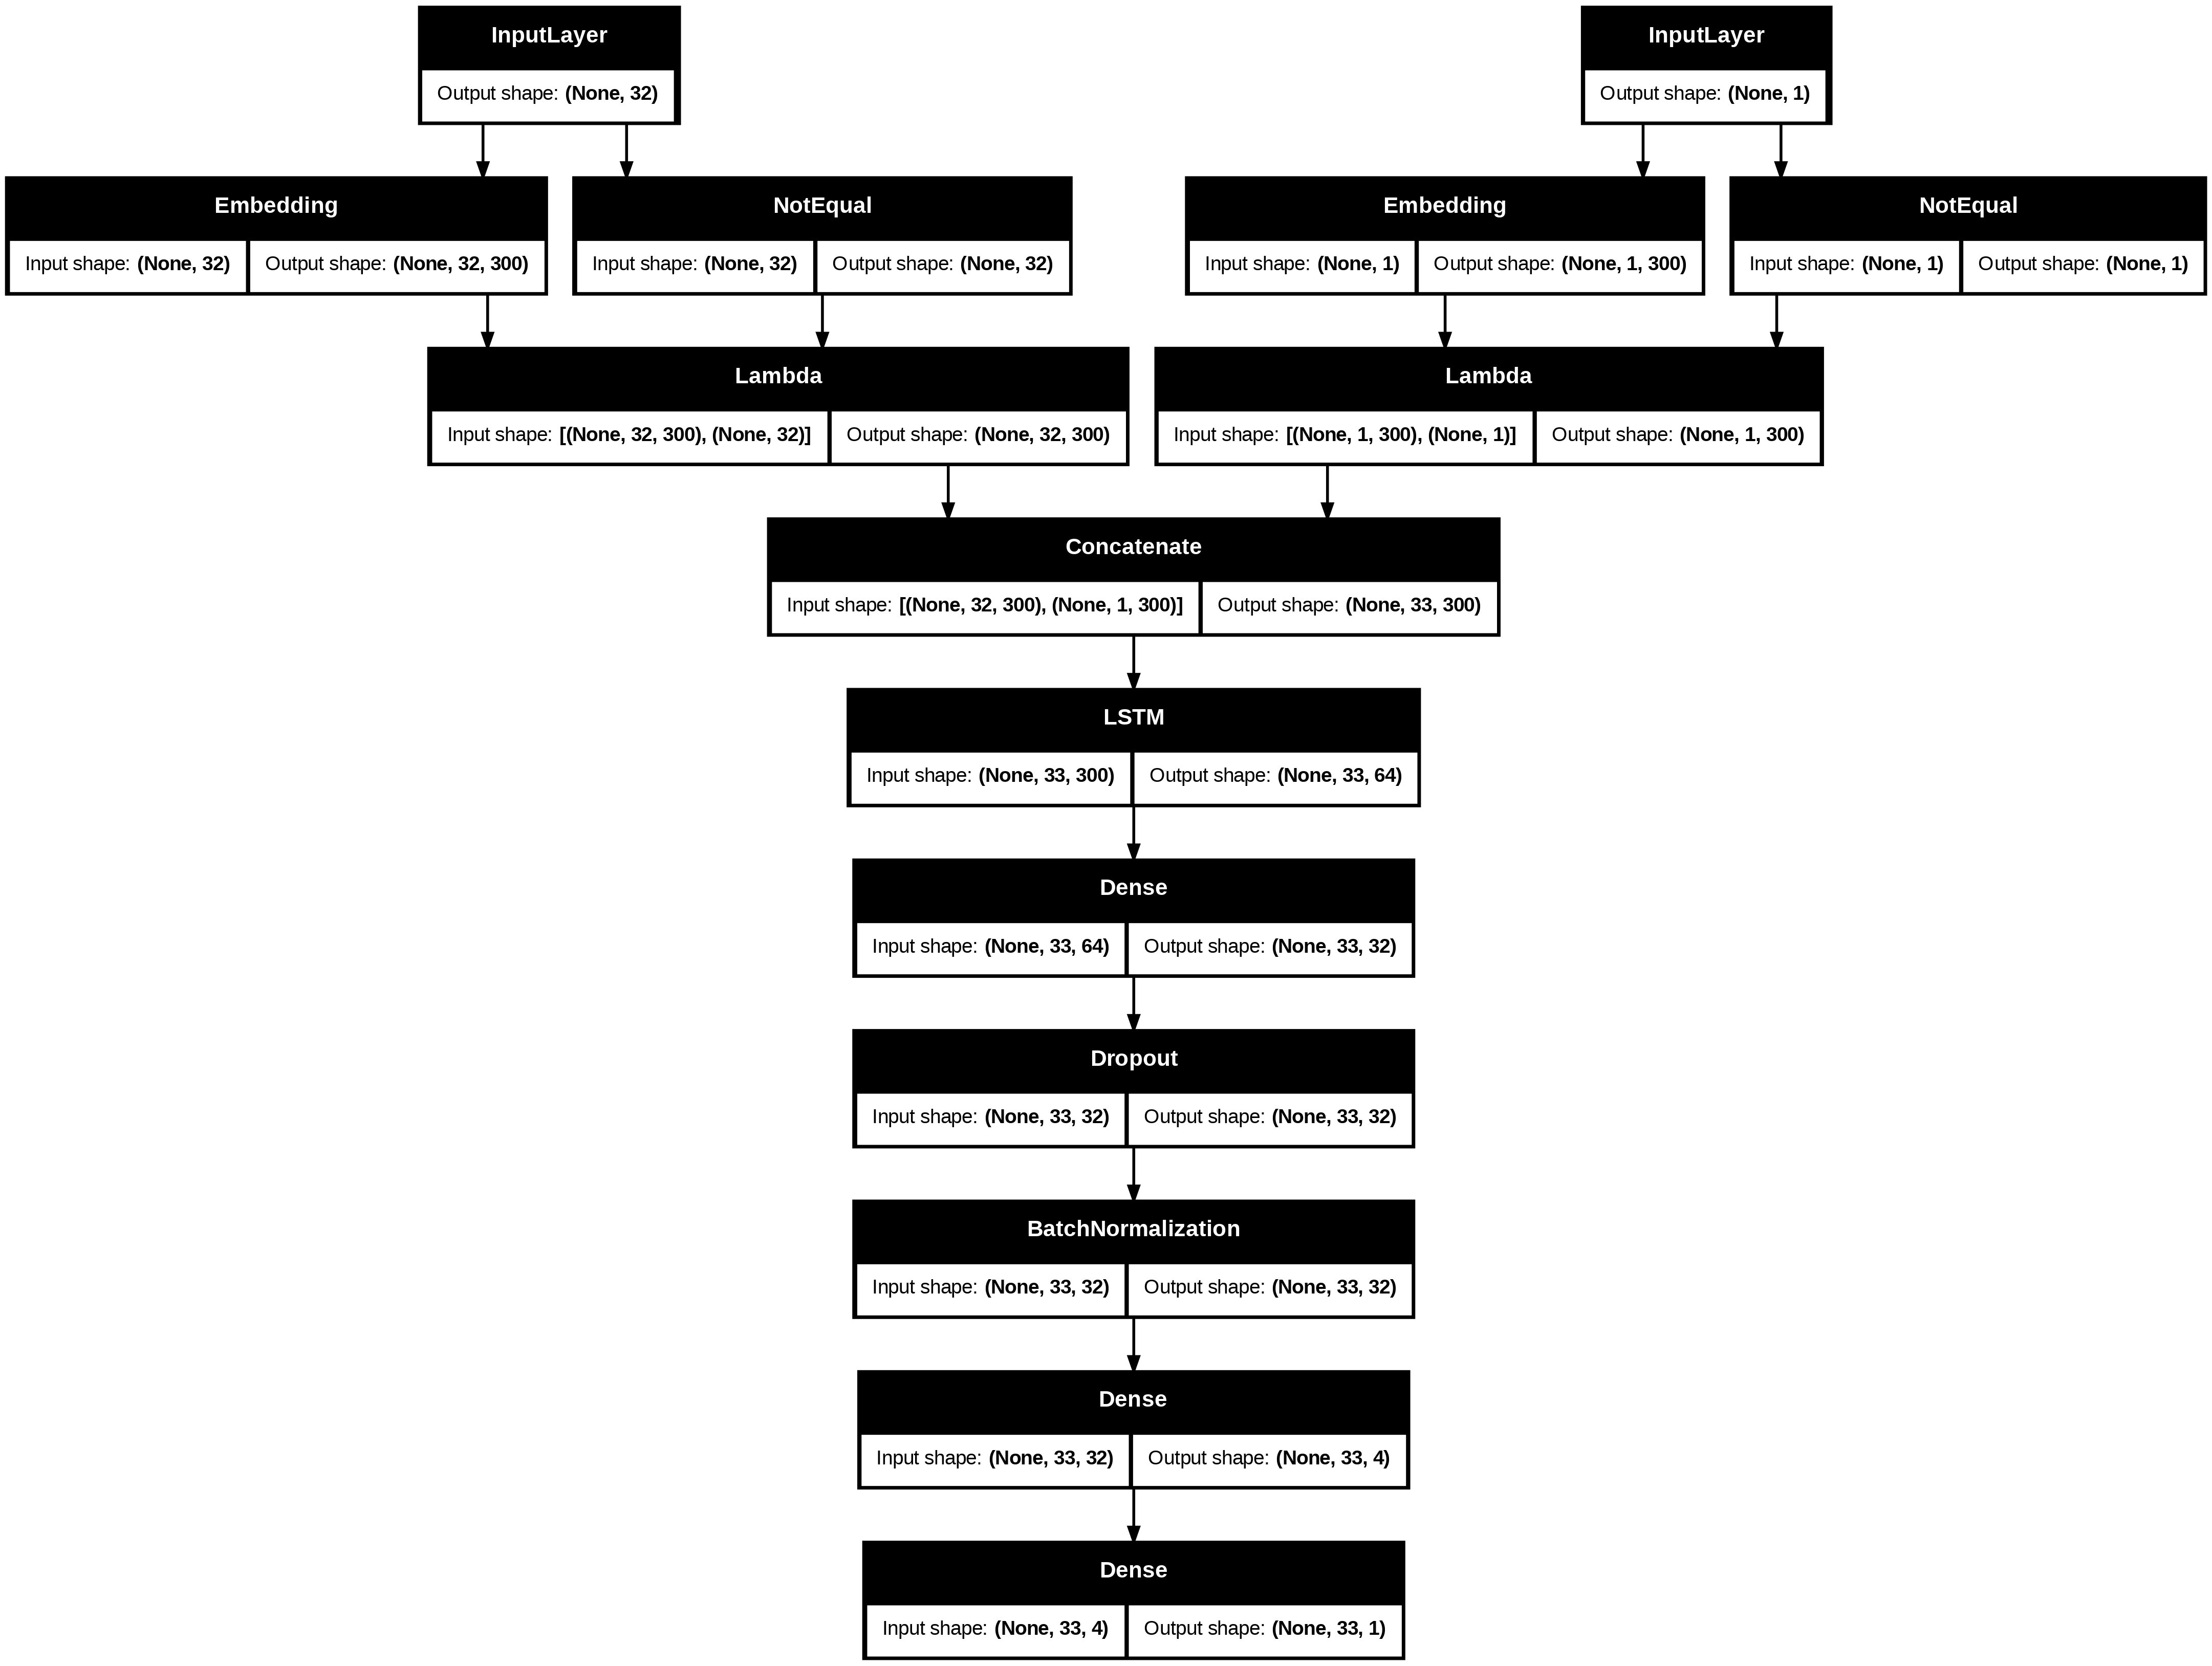

In [ ]:
#summarizing the Model
plot_model(model, 'model.png', show_shapes = True)

In [ ]:
x_train_result = [X_train_text_Padded, np.array(X_train_sentiment_padded)]
x_val_result = [(X_val_text_Padded), np.array(X_val_sentiment_padded)]
x_test_result = [(X_test_text_Padded), np.array(X_test_sentiment_padded)]

In [ ]:
#resulted padded shape
print(X_train_text_Padded.shape, np.array(X_train_sentiment_padded).shape)
print(X_val_text_Padded.shape, np.array(X_val_sentiment_padded).shape)
print(X_test_text_Padded.shape, np.array(X_test_sentiment_padded).shape)

(19778, 32) (19778, 1)
(3491, 32) (3491, 1)
(4107, 32) (4107, 1)


In [ ]:
#logs
! rm -rf ./logs/
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1, write_graph = True)

logs/20250409-150559


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_accuracy(y_true, y_pred):
    # Apply a threshold to convert probabilities to binary predictions (e.g., 0.5 threshold for binary classification)
    y_pred = K.round(y_pred)  # Convert probabilities to binary values: 0 or 1

    # Correct predictions
    correct_predictions = K.equal(y_true, y_pred)
    correct_predictions = K.cast(correct_predictions, dtype=K.floatx())

    # Give higher weight to correct positive class predictions (1 == 1)
    # and lower weight to correct negative class predictions (0 == 0)
    positive_weight = 1  # Higher weight for correct positive predictions
    negative_weight = 0.8  # Lower weight for correct negative predictions

    # Apply weights: multiply by 2 for correct positive predictions and by 1 for correct negative predictions
    weighted_accuracy = K.switch(K.equal(y_true, 1), correct_predictions * positive_weight, correct_predictions * negative_weight)

    # Return mean of weighted accuracy
    return K.mean(weighted_accuracy)

In [ ]:
def custom_loss(y_true, y_pred):
    # Binary crossentropy loss
    bce_loss = K.binary_crossentropy(y_true, y_pred)

    # Weighted accuracy (you can scale it based on your needs)
    w_acc = weighted_accuracy(y_true, y_pred)

    # Combine the two: minimize binary crossentropy and maximize weighted accuracy
    # The weighted accuracy term could be scaled or added to BCE loss
    loss = bce_loss - 0.2 * w_acc  # You can adjust the weight here to control the balance

    return loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(y_true, y_pred, weight_positive=1, weight_negative=0.7):
    # Add small epsilon to prevent log(0)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    # Apply binary cross-entropy formula
    loss = - (y_true * K.log(y_pred) * weight_positive + (1 - y_true) * K.log(1 - y_pred) * weight_negative)

    return K.mean(loss)

In [ ]:
model.compile( optimizer = 'adam', loss = custom_loss, metrics = [weighted_accuracy] )

In [ ]:
model.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
#Model compilation
model.compile( optimizer = 'adam', loss = weighted_binary_crossentropy, metrics = ['accuracy'] )

In [ ]:
#Model fitting
filepath = "/content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras"

checkpoint = ModelCheckpoint(filepath, monitor ='val_accuracy', verbose = 2, save_best_only = True, mode = 'max')
# earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.15, patience = 4, verbose = 1)

# early stopping if accuracy is not increased
# model.fit(x_train_result, y_train, epochs = 15, validation_data = (x_test_result, y_test), batch_size = 64, callbacks = [checkpoint, earlystop, tensorboard_callback])
model.fit(x_train_result, y_train, epochs = 7, validation_data = (x_val_result, y_val), batch_size = 64, callbacks = [checkpoint, tensorboard_callback])

Epoch 1/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8113 - loss: 0.4645
Epoch 1: val_accuracy improved from -inf to 0.82421, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.8113 - loss: 0.4638 - val_accuracy: 0.8242 - val_loss: 0.2951
Epoch 2/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8302 - loss: 0.2517
Epoch 2: val_accuracy improved from 0.82421 to 0.82448, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.8302 - loss: 0.2517 - val_accuracy: 0.8245 - val_loss: 0.2576
Epoch 3/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8317 - loss: 0.2355
Epoch 3: val_accuracy improved from 0.82448 to 0.82456, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.8317 - loss: 0.2355 - val_accurac

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test_result, y_test)

# Print the accuracy
print(f"Test Accuracy: {test_accuracy}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8402 - loss: 0.2984
Test Accuracy: 0.838974118232727


In [ ]:
test_pred = model.predict([X_test_text_Padded, np.asarray(X_test_sentiment_padded)])
test_pred[:3]

129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


array([[[5.6641167e-01],
        [5.6799829e-01],
        [5.4176199e-01],
        [6.2048322e-01],
        [6.2339032e-01],
        [5.6853390e-01],
        [5.3311372e-01],
        [5.5035549e-01],
        [5.5460936e-01],
        [1.4409436e-01],
        [1.1200308e-02],
        [3.3635497e-03],
        [1.6395493e-03],
        [1.0869586e-03],
        [8.6054881e-04],
        [7.5222889e-04],
        [6.9818494e-04],
        [6.7240623e-04],
        [6.6266174e-04],
        [6.6251482e-04],
        [6.6824356e-04],
        [6.7751203e-04],
        [6.8877032e-04],
        [7.0094073e-04],
        [7.1327161e-04],
        [7.2523777e-04],
        [7.3649042e-04],
        [7.4681133e-04],
        [7.5608428e-04],
        [7.6427119e-04],
        [7.7138498e-04],
        [7.7747513e-04],
        [6.2858535e-04]],

       [[5.5417073e-01],
        [6.2043446e-01],
        [5.3071415e-01],
        [3.8150322e-01],
        [4.6130562e-01],
        [5.3499693e-01],
        [2.2317169e-02]

In [ ]:
test_pred_flat = np.squeeze(test_pred)
test_pred_round = np.round(test_pred_flat)
test_pred_round[:3]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [ ]:
y_test_flat = np.squeeze(y_test)  # Flatten the true labels to 1D
y_test_flat[:3]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [ ]:
correct_predictions = np.sum(test_pred_round == y_test_flat)
correct_predictions

np.int64(113707)

In [ ]:
len(test_pred_flat)*33

135531

In [ ]:
# Step 2: Compare predicted and true labels
correct_predictions = np.sum(test_pred_round == y_test_flat)  # Count correct matches

# Step 3: Calculate accuracy
accuracy = correct_predictions / (len(test_pred_flat)*33)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8389741092443795


In [ ]:
#tensor results
%load_ext tensorboard
%tensorboard --logdir $logdir

# Predictions on test data

In [ ]:
test_pred = model.predict([X_test_text_Padded, np.asarray(X_test_sentiment_padded)])

129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


In [ ]:
test_pred[:5]

array([[[5.7702231e-01],
        [5.9142923e-01],
        [5.7075840e-01],
        [6.5434754e-01],
        [6.4926600e-01],
        [6.7205399e-01],
        [6.5427148e-01],
        [6.8485147e-01],
        [6.7223448e-01],
        [2.5507081e-01],
        [1.3700426e-02],
        [2.9951425e-03],
        [1.3125854e-03],
        [8.0136117e-04],
        [5.9045496e-04],
        [4.8702513e-04],
        [4.3245408e-04],
        [4.0293136e-04],
        [3.8775644e-04],
        [3.8137904e-04],
        [3.8065185e-04],
        [3.8365702e-04],
        [3.8915902e-04],
        [3.9632508e-04],
        [4.0457258e-04],
        [4.1348112e-04],
        [4.2274216e-04],
        [4.3212381e-04],
        [4.4145162e-04],
        [4.5059389e-04],
        [4.5945309e-04],
        [4.6795732e-04],
        [4.4894472e-04]],

       [[5.7670009e-01],
        [6.6266406e-01],
        [5.7709384e-01],
        [5.0690424e-01],
        [5.6025255e-01],
        [6.2001806e-01],
        [6.1522350e-02]

In [ ]:
test_pred = model.predict([X_test_text_Padded, np.asarray(X_test_sentiment_padded)])
test_pred = np.squeeze(test_pred)
test_pred = np.round(test_pred)
test_pred.shape

129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


(4107, 33)

In [ ]:
test_pred = np.squeeze(test_pred)
test_pred = np.round(test_pred)

In [ ]:
test_pred[:5]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [ ]:
#text data index prediction
def predict_index(df):
  pred = []
  for vector in df:
    index = []
    for i, value in enumerate(vector):
      if value == 1:
        index.append(i)
    pred.append(np.array(index))

  print(len(pred))
  return pred

In [ ]:
#test prediction
pred = predict_index(test_pred)
#model prediction on test
X_test['prediction'] = pred
X_test.head(4)

4107


,text,sentiment,selected_text,prediction,pred_text
24319,is still stuck in the office working,negative,stuck,"[0, 1, 2, 3, 4, 5, 6]",is still stuck in the office working
13775,bored would love someone to talk to,neutral,bored would love someone to talk to,"[0, 1, 2, 3, 4, 5]",bored would love
20086,still raining here in the bayi forget what sun...,negative,forget,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",still raining here in the bayi what


In [ ]:
#text based on index value
def get_text(x):
  pred = []
  text = x[0]
  index = x[1]
  text = text.split()
  l = len(text)
  for i in index:
    if i < l:
      pred.append(text[i])
  return pred

In [ ]:
#text prediction
pred_text = X_test[['text','prediction']].apply(lambda x: get_text(x), axis = 1)
X_test['pred_text'] = pred_text
X_test['pred_text'] = X_test['pred_text'].apply(lambda x: ' '.join(x))
X_test.head(4)

,text,sentiment,selected_text,prediction,pred_text
9256,more days until ca i get to see my paniniii,neutral,more days until ca i get to see my paniniii,"[0, 1, 2, 3, 4, 5, 6, 7, 8]",more days until ca i get to see my
14081,says misses my cousins so badly,negative,misses my cousins so badly,"[0, 1, 2, 3, 4, 5]",says misses my cousins so badly
8596,congrats i just knew a princess would win s...,positive,congrats,"[0, 1, 2, 3, 4, 5, 6, 7]",congrats i just knew a princess would win
3313,also,neutral,also,"[0, 1]",also


In [ ]:
#Jaccard Similarity
def Jaccard_Similarity_Score(doc1, doc2):

 words_doc1 = set(doc1.lower().split())
 words_doc2 = set(doc2.lower().split())

 #intersection
 intersection = words_doc1.intersection(words_doc2)
 #union
 union = words_doc1.union(words_doc2)

 #return Jaccard similarity scores
 return float(len(intersection)) / len(union)

In [ ]:
#Jaccard score for each sentiment
def jaccard_score(sentiment_type, dftype):
  results_jaccard = []

  for ind, row in dftype[dftype["sentiment"] == str(sentiment_type)].iterrows():
    sentence1 = row.selected_text
    sentence2 = row.pred_text
    jaccard_score = Jaccard_Similarity_Score(sentence1, sentence2)
    results_jaccard.append(jaccard_score)
  return results_jaccard

In [ ]:
results_jaccard = []
for ind, row in X_test.iterrows():
  sentence1 = row.selected_text
  sentence2 = row.pred_text
  jaccard_score = Jaccard_Similarity_Score(sentence1,sentence2)
  results_jaccard.append(jaccard_score)
print("The Jaccard score for test data mean =", np.mean(results_jaccard))

The Jaccard score for test data mean = 0.5564704985921447


In [ ]:
def jaccard_score(sentiment_type,dftype):
  results_jaccard = []
  for ind,row in dftype[dftype["sentiment"] == str(sentiment_type)].iterrows():
    sentence1 = row.selected_text
    sentence2 = row.pred_text
    jaccard_score = Jaccard_Similarity_Score(sentence1,sentence2)
    results_jaccard.append(jaccard_score)
  return  results_jaccard

In [ ]:
#Neutral sentiment
results_jaccard = jaccard_score('neutral', X_test)
print("Jaccard score for Neutral sentiment=", np.mean(results_jaccard))
print("*"*52)

#Negative sentiment
results_jaccard = jaccard_score('negative', X_test)
print("Jaccard score for Negative sentiment=", np.mean(results_jaccard))
print("*"*52)

#Positive sentiment
results_jaccard=jaccard_score('positive', X_test)
print("Jaccard score for Positive sentiment=", np.mean(results_jaccard))
print("*"*52)

Jaccard score for Neutral sentiment= 0.7674246458281571
****************************************************
Jaccard score for Negative sentiment= 0.3299823623677699
****************************************************
Jaccard score for Positive sentiment= 0.32244185643515016
****************************************************


# Deep Learning Model_Two LSTM

In [ ]:
# add one more lstm

from tensorflow.keras.layers import Lambda

tf.keras.backend.clear_session()
text_input = Input(shape = (max_Length_,), name='text_input', dtype='int32')


#glove vector embedding
embd_text = Embedding(vocab_size_is,
                    300,
                    weights = [embedding_matrix],
                    input_length = max_Length_,
                    trainable = False, mask_zero = True, name = 'embedding_text')(text_input)


sentiment_input = Input(shape = (1,), name = 'sentiment_input', dtype='int32')

embd_sentiment = Embedding(4,
                    300,
                    weights = [embedding_matrix_sentiment],
                    input_length = 1,
                    trainable = False, mask_zero = True, name = 'embedding_sentiment')(sentiment_input)

#debug: try another way
def identity_force_infer(x):
    return tf.identity(x)

embd_text_checked = Lambda(identity_force_infer)(embd_text)
embd_sentiment_checked = Lambda(identity_force_infer)(embd_sentiment)

con = layers.Concatenate(axis=1)([embd_text_checked, embd_sentiment_checked])


#LSTM
lstm = LSTM(64, return_sequences = True, kernel_regularizer = regularizers.l2(0.001), name = 'LSTM_1')(con)

#Dense Layer with the dropouts
m = Dense(32, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(lstm)
m = Dropout(0.5)(m)
m = BatchNormalization()(m)
m = Dense(16, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(m)
m = Dropout(0.5)(m)
lstm = LSTM(32, return_sequences = True, kernel_regularizer = regularizers.l2(0.001), name = 'LSTM_2')(m)
m = Dense(4, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(lstm)
output = Dense(1, activation = 'sigmoid', name = 'output')(m)

model = Model(inputs = [text_input, sentiment_input], outputs = [output])

#model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_text            │ (None, 32, 300)        │      6,459,900 │ text_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 32)             │              0 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_sentiment       │ (None, 1, 300)         │          1,200 │ sentiment_input[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 1)              │              0 │ sentiment_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32, 300)        │              0 │ embedding_text[0][0],  │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 300)         │              0 │ embedding_sentiment[0… │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 33, 300)        │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM_1 (LSTM)             │ (None, 33, 64)         │         93,440 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 33, 32)         │          2,080 │ LSTM_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 33, 32)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 33, 32)         │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 33, 16)         │            528 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 33, 16)         │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM_2 (LSTM)             │ (None, 33, 32)         │          6,272 │ dropout_1[0][0]        │
├──────────────────────

 Total params: 6,563,685 (25.04 MB)

 Trainable params: 102,521 (400.47 KB)

 Non-trainable params: 6,461,164 (24.65 MB)

None


In [ ]:
#logs
! rm -rf ./logs/
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1, write_graph = True)

logs/20250409-074808


In [ ]:
#Model compilation
model.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
#Model fitting
filepath = "/content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras"

checkpoint = ModelCheckpoint(filepath, monitor ='val_accuracy', verbose = 2, save_best_only = True, mode = 'max')
# earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.15, patience = 4, verbose = 1)

# early stopping if accuracy is not increased
# model.fit(x_train_result, y_train, epochs = 15, validation_data = (x_test_result, y_test), batch_size = 64, callbacks = [checkpoint, earlystop, tensorboard_callback])
model.fit(x_train_result, y_train, epochs = 7, validation_data = (x_val_result, y_val), batch_size = 64, callbacks = [checkpoint, tensorboard_callback])

Epoch 1/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8338 - loss: 0.2870
Epoch 1: val_accuracy improved from -inf to 0.83453, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 39s 126ms/step - accuracy: 0.8338 - loss: 0.2870 - val_accuracy: 0.8345 - val_loss: 0.2984
Epoch 2/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8430 - loss: 0.2775
Epoch 2: val_accuracy did not improve from 0.83453
310/310 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.8429 - loss: 0.2775 - val_accuracy: 0.8344 - val_loss: 0.2985
Epoch 3/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8398 - loss: 0.2781
Epoch 3: val_accuracy did not improve from 0.83453
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.8398 - loss: 0.2781 - val_accuracy: 0.8228 - val_loss: 0.3215
Epoch 4/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8401 - loss: 0.2794
Epoch 4: val_accuracy did not improve from 0.83453
310/310 

In [ ]:
test_pred = model.predict([X_test_text_Padded, np.asarray(X_test_sentiment_padded)])
test_pred = np.squeeze(test_pred)
test_pred = np.round(test_pred)
test_pred.shape

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step


(4107, 33)

In [ ]:
#test prediction
pred = predict_index(test_pred)
#model prediction on test
X_test['prediction'] = pred
X_test.sample(3)

4107


,text,sentiment,selected_text,prediction,pred_text
13430,mejer i couldnt remember what all the differen...,negative,could not remember wh,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",mejer i couldnt remember what all different co...
27324,i have heard of disgruntled investors but cal...,negative,that seems totally out of line,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",i have heard of disgruntled investors but call...
17347,milk gran torino bolt bride wars new in town ...,positive,love,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",milk gran torino bolt bride wars town yeah i g...


In [ ]:
#text prediction
pred_text = X_test[['text','prediction']].apply(lambda x: get_text(x), axis = 1)
X_test['pred_text'] = pred_text
X_test['pred_text'] = X_test['pred_text'].apply(lambda x: ' '.join(x))
X_test.head(4)

,text,sentiment,selected_text,prediction,pred_text
9256,more days until ca i get to see my paniniii,neutral,more days until ca i get to see my paniniii,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",more days until ca i get to see my paniniii
14081,says misses my cousins so badly,negative,misses my cousins so badly,"[0, 1, 2, 3, 4, 5]",says misses my cousins so badly
8596,congrats i just knew a princess would win s...,positive,congrats,"[0, 1, 7]",congrats i win
3313,also,neutral,also,"[0, 1]",also


In [ ]:
results_jaccard = []
for ind, row in X_test.iterrows():
  sentence1 = row.selected_text
  sentence2 = row.pred_text
  jaccard_score = Jaccard_Similarity_Score(sentence1,sentence2)
  results_jaccard.append(jaccard_score)
print("The Jaccard score for test data mean =", np.mean(results_jaccard))

The Jaccard score for test data mean = 0.5564704985921447


In [ ]:
def jaccard_score(sentiment_type,dftype):
  results_jaccard = []
  for ind,row in dftype[dftype["sentiment"] == str(sentiment_type)].iterrows():
    sentence1 = row.selected_text
    sentence2 = row.pred_text
    jaccard_score = Jaccard_Similarity_Score(sentence1,sentence2)
    results_jaccard.append(jaccard_score)
  return  results_jaccard

In [ ]:
#Neutral sentiment
results_jaccard = jaccard_score('neutral', X_test)
print("Jaccard score for Neutral sentiment=", np.mean(results_jaccard))
print("*"*52)

#Negative sentiment
results_jaccard = jaccard_score('negative', X_test)
print("Jaccard score for Negative sentiment=", np.mean(results_jaccard))
print("*"*52)

#Positive sentiment
results_jaccard=jaccard_score('positive', X_test)
print("Jaccard score for Positive sentiment=", np.mean(results_jaccard))
print("*"*52)

Jaccard score for Neutral sentiment= 0.8882017031505723
****************************************************
Jaccard score for Negative sentiment= 0.33681672352607395
****************************************************
Jaccard score for Positive sentiment= 0.32204939641092356
****************************************************


# Deep Learning Model_BiLSTM

In [ ]:
#BiLSTM

from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Lambda

tf.keras.backend.clear_session()
text_input = Input(shape = (max_Length_,), name = 'text_input')

#embedding layer using glove vector
embd_text = Embedding(vocab_size_is,
                      300,
                      weights = [embedding_matrix],
                      input_length = max_Length_,
                      trainable = False,
                      mask_zero = True, name = 'embedding_text')(text_input)

sentiment_input = Input(shape = (1,), name = 'sentiment_input')
embd_sentiment = Embedding(4,
                           300,
                           weights = [embedding_matrix_sentiment],
                           input_length = 1,
                           trainable = False,
                           mask_zero = True, name = 'embedding_sentiment')(sentiment_input)

# con = layers.Concatenate(axis = 1)([embd_text, embd_sentiment])

def identity_force_infer(x):
    return tf.identity(x)

embd_text_checked = Lambda(identity_force_infer)(embd_text)
embd_sentiment_checked = Lambda(identity_force_infer)(embd_sentiment)

con = layers.Concatenate(axis=1)([embd_text_checked, embd_sentiment_checked])

#BiLSTM
Bilstm = Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer = regularizers.l2(0.001), name = 'BiLSTM'))(con)

# Dense layer with dropouts
l = Dense(32, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(Bilstm)
l = Dropout(0.5)(l)
l = BatchNormalization()(l)
l = Dense(4, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(l)

#output
output = Dense(1, activation = 'sigmoid', name = 'output')(l)
model = Model(inputs = [text_input, sentiment_input], outputs = [output])
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_text            │ (None, 32, 300)        │      5,623,200 │ text_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 32)             │              0 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_sentiment       │ (None, 1, 300)         │          1,200 │ sentiment_input[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 1)              │              0 │ sentiment_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32, 300)        │              0 │ embedding_text[0][0],  │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 300)         │              0 │ embedding_sentiment[0… │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 33, 300)        │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 33, 128)        │        186,880 │ concatenate[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 33, 32)         │          4,128 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 33, 32)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 33, 32)         │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 33, 4)          │            132 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 33, 1)          │              5 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,815,673 (22.19 MB)

 Trainable params: 191,209 (746.91 KB)

 Non-trainable params: 5,624,464 (21.46 MB)

None


In [ ]:
#logs
! rm -rf ./logs/
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1, write_graph = True)

logs/20250410-125242


In [ ]:
#Model compilation
model.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
model.compile( optimizer = 'adam', loss = weighted_binary_crossentropy, metrics = ['accuracy'] )

In [ ]:
#Model fitting
filepath = "/content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras"

checkpoint = ModelCheckpoint(filepath, monitor ='val_accuracy', verbose = 2, save_best_only = True, mode = 'max')
# earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.15, patience = 4, verbose = 1)

# early stopping if accuracy is not increased
# model.fit(x_train_result, y_train, epochs = 15, validation_data = (x_test_result, y_test), batch_size = 64, callbacks = [checkpoint, earlystop, tensorboard_callback])
model.fit(x_train_result, y_train, epochs = 7, validation_data = (x_val_result, y_val), batch_size = 64, callbacks = [checkpoint, tensorboard_callback])

Epoch 1/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8323 - loss: 0.6941
Epoch 1: val_accuracy improved from -inf to 0.92130, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - accuracy: 0.8326 - loss: 0.6924 - val_accuracy: 0.9213 - val_loss: 0.2337
Epoch 2/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9260 - loss: 0.1962
Epoch 2: val_accuracy improved from 0.92130 to 0.92708, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.9260 - loss: 0.1961 - val_accuracy: 0.9271 - val_loss: 0.1923
Epoch 3/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9312 - loss: 0.1668
Epoch 3: val_accuracy did not improve from 0.92708
310/310 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.9312 - loss: 0.1667 - val_accuracy: 0.9246 - val_loss: 0.1843
Epoch 4/7
309/310 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step 

In [ ]:
test_pred = model.predict([X_test_text_Padded, np.asarray(X_test_sentiment_padded)])
test_pred[:5]

129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step


array([[[7.67234087e-01],
        [7.67234087e-01],
        [7.67234087e-01],
        [7.67234087e-01],
        [7.67234087e-01],
        [7.67234087e-01],
        [7.67234087e-01],
        [7.67234087e-01],
        [7.67234087e-01],
        [1.06082335e-01],
        [8.88922717e-03],
        [2.46140943e-03],
        [1.10319385e-03],
        [6.63176877e-04],
        [4.79780574e-04],
        [3.90839501e-04],
        [3.43280000e-04],
        [3.15702549e-04],
        [2.98031751e-04],
        [2.85011745e-04],
        [2.73767888e-04],
        [2.62745365e-04],
        [2.51158985e-04],
        [2.38680281e-04],
        [2.25241674e-04],
        [2.10932718e-04],
        [1.95940534e-04],
        [1.80523886e-04],
        [1.64985948e-04],
        [1.49646352e-04],
        [1.34806920e-04],
        [1.20696925e-04],
        [2.17624081e-04]],

       [[2.79775918e-01],
        [3.26537073e-01],
        [3.26621741e-01],
        [3.22739363e-01],
        [4.84451026e-01],
        [7

In [ ]:
test_pred = np.squeeze(test_pred)
test_pred = np.round(test_pred)
test_pred[:5]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [ ]:
y_test[:5]

array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        [0.],
        [0.],
  

In [ ]:
test_pred_flat = np.squeeze(test_pred)  # Flatten the predicted labels to 1D
y_test_flat = np.squeeze(y_test)  # Flatten the true labels to 1D

# Step 2: Compare predicted and true labels
correct_predictions = np.sum(test_pred_flat == y_test_flat)  # Count correct matches

# Step 3: Calculate accuracy
accuracy = correct_predictions / len(test_pred_flat)
print(f"Accuracy: {accuracy}")

Accuracy: 30.614317019722424


In [ ]:
test_pred = model.predict([X_test_text_Padded, np.asarray(X_test_sentiment_padded)])
test_pred = np.squeeze(test_pred)
test_pred = np.round(test_pred)
test_pred.shape

129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


(4107, 33)

In [ ]:
#test prediction
pred = predict_index(test_pred)
#model prediction on test
X_test['prediction'] = pred
X_test.head(4)

4107


,text,sentiment,selected_text,prediction,pred_text
9256,more days until ca i get to see my paniniii,neutral,more days until ca i get to see my paniniii,"[0, 1, 2, 3, 4, 5, 6, 7, 8]",more days until ca i get to see my paniniii
14081,says misses my cousins so badly,negative,misses my cousins so badly,[5],says misses my cousins so badly
8596,congrats i just knew a princess would win s...,positive,congrats,[7],congrats i just knew a princess would win
3313,also,neutral,also,[0],also


In [ ]:
#text prediction
pred_text = X_test[['text','prediction']].apply(lambda x: get_text(x), axis = 1)
X_test['pred_text'] = pred_text
X_test['pred_text'] = X_test['pred_text'].apply(lambda x: ' '.join(x))
X_test.head(4)

,text,sentiment,selected_text,prediction,pred_text
9256,more days until ca i get to see my paniniii,neutral,more days until ca i get to see my paniniii,"[0, 1, 2, 3, 4, 5, 6, 7, 8]",more days until ca i get to see my
14081,says misses my cousins so badly,negative,misses my cousins so badly,[5],badly
8596,congrats i just knew a princess would win s...,positive,congrats,[7],win
3313,also,neutral,also,[0],also


In [ ]:
results_jaccard = []
for ind, row in X_test.iterrows():
  sentence1 = row.selected_text
  sentence2 = row.pred_text
  jaccard_score = Jaccard_Similarity_Score(sentence1,sentence2)
  results_jaccard.append(jaccard_score)
print("The Jaccard score for test data mean =", np.mean(results_jaccard))

The Jaccard score for test data mean = 0.5564704985921447


In [ ]:
def jaccard_score(sentiment_type,dftype):
  results_jaccard = []
  for ind,row in dftype[dftype["sentiment"] == str(sentiment_type)].iterrows():
    sentence1 = row.selected_text
    sentence2 = row.pred_text
    jaccard_score = Jaccard_Similarity_Score(sentence1,sentence2)
    results_jaccard.append(jaccard_score)
  return  results_jaccard

In [ ]:
#Neutral sentiment
results_jaccard = jaccard_score('neutral', X_test)
print("Jaccard score for Neutral sentiment=", np.mean(results_jaccard))
print("*"*52)

#Negative sentiment
results_jaccard = jaccard_score('negative', X_test)
print("Jaccard score for Negative sentiment=", np.mean(results_jaccard))
print("*"*52)

#Positive sentiment
results_jaccard=jaccard_score('positive', X_test)
print("Jaccard score for Positive sentiment=", np.mean(results_jaccard))
print("*"*52)

Jaccard score for Neutral sentiment= 0.9147160376902445
****************************************************
Jaccard score for Negative sentiment= 0.24852631984250365
****************************************************
Jaccard score for Positive sentiment= 0.306868768207903
****************************************************


# Deep Learning Two Model_BiLSTM

In [ ]:
#Two BiLSTM

from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Lambda

tf.keras.backend.clear_session()
text_input = Input(shape = (max_Length_,), name = 'text_input')

#embedding layer using glove vector
embd_text = Embedding(vocab_size_is,
                      300,
                      weights = [embedding_matrix],
                      input_length = max_Length_,
                      trainable = False,
                      mask_zero = True, name = 'embedding_text')(text_input)

sentiment_input = Input(shape = (1,), name = 'sentiment_input')
embd_sentiment = Embedding(4,
                           300,
                           weights = [embedding_matrix_sentiment],
                           input_length = 1,
                           trainable = False,
                           mask_zero = True, name = 'embedding_sentiment')(sentiment_input)

# con = layers.Concatenate(axis = 1)([embd_text, embd_sentiment])

def identity_force_infer(x):
    return tf.identity(x)

embd_text_checked = Lambda(identity_force_infer)(embd_text)
embd_sentiment_checked = Lambda(identity_force_infer)(embd_sentiment)

con = layers.Concatenate(axis=1)([embd_text_checked, embd_sentiment_checked])

#BiLSTM
Bilstm = Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer = regularizers.l2(0.001), name = 'BiLSTM'))(con)

# Dense layer with dropouts
l = Dense(32, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(Bilstm)
l = Dropout(0.5)(l)
l = BatchNormalization()(l)
l = Dense(16, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(l)

#BiLSTM
Bilstm = Bidirectional(LSTM(32, return_sequences = True, kernel_regularizer = regularizers.l2(0.001), name = 'BiLSTM_2'))(l)
l = Dense(4, activation = "relu", kernel_initializer = "he_normal", kernel_regularizer = regularizers.l2(0.001))(Bilstm)

#output
output = Dense(1, activation = 'sigmoid', name = 'output')(l)
model = Model(inputs = [text_input, sentiment_input], outputs = [output])
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_text            │ (None, 32, 300)        │      5,623,200 │ text_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 32)             │              0 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_sentiment       │ (None, 1, 300)         │          1,200 │ sentiment_input[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 1)              │              0 │ sentiment_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 32, 300)        │              0 │ embedding_text[0][0],  │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 300)         │              0 │ embedding_sentiment[0… │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 33, 300)        │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 33, 128)        │        186,880 │ concatenate[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 33, 32)         │          4,128 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 33, 32)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 33, 32)         │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 33, 16)         │            528 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 33, 64)         │         12,544 │ dense_1[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├──────────────────────

 Total params: 5,828,873 (22.24 MB)

 Trainable params: 204,409 (798.47 KB)

 Non-trainable params: 5,624,464 (21.46 MB)

None


In [ ]:
model.compile( optimizer = 'adam', loss = weighted_binary_crossentropy, metrics = ['accuracy'] )

In [ ]:
model.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
#Model fitting
filepath = "/content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras"

checkpoint = ModelCheckpoint(filepath, monitor ='val_accuracy', verbose = 2, save_best_only = True, mode = 'max')
# earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.15, patience = 4, verbose = 1)

# early stopping if accuracy is not increased
# model.fit(x_train_result, y_train, epochs = 15, validation_data = (x_test_result, y_test), batch_size = 64, callbacks = [checkpoint, earlystop, tensorboard_callback])
model.fit(x_train_result, y_train, epochs = 7, validation_data = (x_val_result, y_val), batch_size = 64, callbacks = [checkpoint, tensorboard_callback])

Epoch 1/7
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8319 - loss: 0.6152
Epoch 1: val_accuracy improved from -inf to 0.81138, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.8321 - loss: 0.6144 - val_accuracy: 0.8114 - val_loss: 0.2981
Epoch 2/7
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9155 - loss: 0.2151
Epoch 2: val_accuracy improved from 0.81138 to 0.90846, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - accuracy: 0.9155 - loss: 0.2150 - val_accuracy: 0.9085 - val_loss: 0.2053
Epoch 3/7
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9198 - loss: 0.1821
Epoch 3: val_accuracy improved from 0.90846 to 0.91393, saving model to /content/Tweet_LSTM_model_results/weights_Updated_new_2.best.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 43s 130ms/step - accuracy: 0.9198 - loss: 0.1821 - val_a

In [ ]:
test_pred = model.predict([X_test_text_Padded, np.asarray(X_test_sentiment_padded)])
test_pred = np.squeeze(test_pred)
test_pred = np.round(test_pred)
test_pred.shape

103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step


(3273, 33)

In [ ]:
#test prediction
pred = predict_index(test_pred)
#model prediction on test
X_test['prediction'] = pred
X_test.head(4)

3273


,text,sentiment,selected_text,prediction
23139,ok so im hungry im fat i knowi know aha,negative,ok so im hungry im fat i knowi know aha,[3]
5473,if its too hard go to ur guy peicing person a...,negative,hard,[16]
22186,is not watching star trek tonight but is headi...,positive,lovely,"[11, 14]"
20696,omg you arent online shock horror,negative,shock horror,"[4, 5]"


In [ ]:
pred_text = X_test[['text','prediction']].apply(lambda x: get_text(x), axis = 1)
X_test['pred_text'] = pred_text
X_test['pred_text'] = X_test['pred_text'].apply(lambda x: ' '.join(x))
X_test.head(4)

,text,sentiment,selected_text,prediction,pred_text
23139,ok so im hungry im fat i knowi know aha,negative,ok so im hungry im fat i knowi know aha,[3],hungry
5473,if its too hard go to ur guy peicing person a...,negative,hard,[16],mine
22186,is not watching star trek tonight but is headi...,positive,lovely,"[11, 14]",lovely fun
20696,omg you arent online shock horror,negative,shock horror,"[4, 5]",shock horror


In [ ]:
results_jaccard = []
for ind, row in X_test.iterrows():
  sentence1 = row.selected_text
  sentence2 = row.pred_text
  jaccard_score = Jaccard_Similarity_Score(sentence1,sentence2)
  results_jaccard.append(jaccard_score)
print("The Jaccard score for test data mean =", np.mean(results_jaccard))

The Jaccard score for test data mean = 0.48263110074582594


In [ ]:
def jaccard_score(sentiment_type,dftype):
  results_jaccard = []
  for ind,row in dftype[dftype["sentiment"] == str(sentiment_type)].iterrows():
    sentence1 = row.selected_text
    sentence2 = row.pred_text
    jaccard_score = Jaccard_Similarity_Score(sentence1,sentence2)
    results_jaccard.append(jaccard_score)
  return  results_jaccard

In [ ]:
#Neutral sentiment
results_jaccard = jaccard_score('neutral', X_test)
print("Jaccard score for Neutral sentiment=", np.mean(results_jaccard))
print("*"*52)

#Negative sentiment
results_jaccard = jaccard_score('negative', X_test)
print("Jaccard score for Negative sentiment=", np.mean(results_jaccard))
print("*"*52)

#Positive sentiment
results_jaccard=jaccard_score('positive', X_test)
print("Jaccard score for Positive sentiment=", np.mean(results_jaccard))
print("*"*52)

Jaccard score for Neutral sentiment= 0.912007094007763
****************************************************
Jaccard score for Negative sentiment= 0.32732748384506655
****************************************************
Jaccard score for Positive sentiment= 0.3438547743273192
****************************************************
